## Setup and Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter, defaultdict

## Part 1: Tokenization from Scratch

Building BPE and WordPiece tokenizers from the ground up.

### Understanding Tokenization: From Raw Text to IDs

Text cannot be fed directly to neural networks. We need to:
1. Break text into units (tokens)
2. Map each token to a unique ID
3. Create a vocabulary (token -> ID mapping)

In [2]:
# Load a sample from the dataset
import json
with open('../.data/en_fa_train.jsonl', 'r', encoding='utf-8') as f:
    first_sample = json.loads(f.readline())

# Simple character-level tokenization (baseline)
text = first_sample['input']

# Character vocabulary
vocab = sorted(set(text))
char_to_id = {char: idx for idx, char in enumerate(vocab)}
id_to_char = {idx: char for char, idx in char_to_id.items()}

print("Character Vocabulary:")
print(char_to_id)
print(f"\nVocabulary size: {len(vocab)}")

# Tokenize
char_tokens = [char_to_id[c] for c in text]
print(f"\nText: '{text}'")
print(f"Tokenized: {char_tokens}")
print(f"Sequence length: {len(char_tokens)}")


Character Vocabulary:
{' ': 0, "'": 1, '.': 2, 'I': 3, 'J': 4, 'a': 5, 'b': 6, 'c': 7, 'd': 8, 'e': 9, 'f': 10, 'g': 11, 'h': 12, 'i': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'y': 24}

Vocabulary size: 25

Text: 'I invited my foolish friend Jay around for tennis because I thought he'd make me look good.'
Tokenized: [3, 0, 13, 17, 23, 13, 21, 9, 8, 0, 16, 24, 0, 10, 18, 18, 15, 13, 20, 12, 0, 10, 19, 13, 9, 17, 8, 0, 4, 5, 24, 0, 5, 19, 18, 22, 17, 8, 0, 10, 18, 19, 0, 21, 9, 17, 17, 13, 20, 0, 6, 9, 7, 5, 22, 20, 9, 0, 3, 0, 21, 12, 18, 22, 11, 12, 21, 0, 12, 9, 1, 8, 0, 16, 5, 14, 9, 0, 16, 9, 0, 15, 18, 18, 14, 0, 11, 18, 18, 8, 2]
Sequence length: 91


**Problem with character-level tokenization:** Long sequences, limited semantic meaning per token.

### Building Byte Pair Encoding (BPE) from Scratch

In [3]:
import json
from collections import defaultdict, Counter

# Load English-Farsi translation data
with open('../.data/en_fa_train.jsonl', 'r', encoding='utf-8') as f:
    samples = [json.loads(line) for line in f]

# Extract English sentences from first 50 translation pairs
english_texts = [sample['input'] for sample in samples[:50]]
real_text = ' '.join(english_texts)

class SimpleBPE:
    """
    Simple Byte Pair Encoding implementation.
    Learns merges from a corpus of words (no merges across whitespace).
    """
    def __init__(self, vocab_size=100):
        self.vocab_size = vocab_size
        self.merges = []          # ordered list of pairs [(left, right), ...]
        self.vocab = None
        self.word_to_id = None

    def _count_pairs(self, words_tokens, word_freq):
        pairs = defaultdict(int)
        for word, tokens in words_tokens.items():
            freq = word_freq[word]
            for i in range(len(tokens) - 1):
                pairs[(tokens[i], tokens[i + 1])] += freq
        return pairs

    def train(self, corpus):
        """
        Train BPE on a text corpus (string). Splits on whitespace and learns merges
        within words only.
        """
        # Split into words and count frequencies
        words = corpus.split()
        word_freq = Counter(words)

        # Initialize word token representations (list of chars)
        words_tokens = {w: list(w) for w in word_freq}

        # Initial vocab = all characters seen + [UNK]
        vocab = set(ch for w in words_tokens for ch in words_tokens[w])
        vocab.add('[UNK]')

        # Learn merges up to target vocab size
        while len(vocab) < self.vocab_size:
            pairs = self._count_pairs(words_tokens, word_freq)
            if not pairs:
                break

            # Most frequent adjacent pair
            best_pair = max(pairs, key=pairs.get)
            left, right = best_pair
            merge_symbol = left + right

            # Apply merge to all word token lists
            for w, tokens in list(words_tokens.items()):
                if len(tokens) < 2:
                    continue
                new_tokens = []
                j = 0
                while j < len(tokens):
                    if j < len(tokens) - 1 and tokens[j] == left and tokens[j + 1] == right:
                        new_tokens.append(merge_symbol)
                        j += 2
                    else:
                        new_tokens.append(tokens[j])
                        j += 1
                words_tokens[w] = new_tokens

            # record merge and update vocab
            self.merges.append((left, right))
            vocab.add(merge_symbol)

            # safety: stop if no new pairs will be created
            # (next iteration _count_pairs may return empty)
        # finalize vocab and id mapping
        # keep [UNK] at id 0
        sorted_vocab = sorted([v for v in vocab if v != '[UNK]'])
        self.vocab = ['[UNK]'] + sorted_vocab
        self.word_to_id = {tok: idx for idx, tok in enumerate(self.vocab)}

    def encode(self, text):
        """
        Encode a text string using the learned merges.
        Returns (token_ids, tokens) where tokens is a flat list across words.
        Unknown tokens map to id 0 ([UNK]).
        """
        tokens_out = []
        words = text.split()
        for w in words:
            tokens = list(w)
            # apply merges in the learned order
            for left, right in self.merges:
                if len(tokens) < 2:
                    break
                new_tokens = []
                j = 0
                while j < len(tokens):
                    if j < len(tokens) - 1 and tokens[j] == left and tokens[j + 1] == right:
                        new_tokens.append(left + right)
                        j += 2
                    else:
                        new_tokens.append(tokens[j])
                        j += 1
                tokens = new_tokens
            tokens_out.extend(tokens)
            # Optionally keep a separator token between words if it exists in vocab
            if ' ' in self.word_to_id:
                tokens_out.append(' ')

        # remove trailing separator if added
        if tokens_out and tokens_out[-1] == ' ':
            tokens_out = tokens_out[:-1]

        ids = [self.word_to_id.get(t, 0) for t in tokens_out]
        return ids, tokens_out

bpe = SimpleBPE(vocab_size=100)
bpe.train(real_text)

print("Learned Merges (first 15):")
for i, (left, right) in enumerate(bpe.merges[:15]):
    print(f"  {i+1}: ({left!r}, {right!r}) -> {left+right!r}")

print(f"\nFinal vocabulary size: {len(bpe.vocab)}")
print(f"Sample vocabulary: {bpe.vocab[:30]}")


Learned Merges (first 15):
  1: ('h', 'e') -> 'he'
  2: ('o', 'u') -> 'ou'
  3: ('i', 'n') -> 'in'
  4: ('t', 'he') -> 'the'
  5: ('i', 't') -> 'it'
  6: ('o', 'r') -> 'or'
  7: ('r', 'e') -> 're'
  8: ('v', 'e') -> 've'
  9: ('o', 'n') -> 'on'
  10: ('i', 's') -> 'is'
  11: ('e', 'd') -> 'ed'
  12: ('a', 'n') -> 'an'
  13: ('t', 'h') -> 'th'
  14: ('a', 't') -> 'at'
  15: ('y', 'ou') -> 'you'

Final vocabulary size: 100
Sample vocabulary: ['[UNK]', '!', "'", "'s", "'t", ',', '.', '..', '0', '9', '?', 'A', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'N', 'O', 'P', 'S', 'T', 'V', 'W', 'Y', 'a', 'an']


In [4]:
# Encode a different sentence with learned BPE
test_sentence = samples[5]['input']
token_ids, tokens = bpe.encode(test_sentence)

print(f"Original text: '{test_sentence}'")
print(f"BPE tokens: {tokens}")
print(f"Token IDs: {token_ids}")
print(f"Sequence length: {len(token_ids)} tokens (vs {len(test_sentence)} characters)")


Original text: 'If it wasn't for Harry we wouldn't even know Voldemort was back.'
BPE tokens: ['I', 'f', 'it', 'was', 'n', "'t", 'for', 'H', 'ar', 'r', 'y', 'we', 'w', 'ould', 'n', "'t", 'e', 've', 'n', 'k', 'no', 'w', 'V', 'o', 'ld', 'e', 'm', 'or', 't', 'was', 'b', 'a', 'c', 'k', '.']
Token IDs: [17, 43, 57, 94, 66, 4, 44, 16, 30, 78, 97, 95, 93, 76, 66, 4, 39, 91, 66, 59, 68, 93, 25, 70, 61, 39, 63, 74, 85, 94, 35, 28, 37, 59, 6]
Sequence length: 35 tokens (vs 64 characters)


### Building WordPiece from Scratch

In [5]:
import re

class SimpleWordPiece:
    """
    Simple WordPiece implementation.
    Builds a subword vocabulary by counting frequent adjacent token concatenations.
    Encoding uses a greedy longest-match approach. Continuation subwords are
    displayed with '##' but IDs map to the base subword (no '##' in vocab).
    """
    def __init__(self, vocab_size=100):
        self.vocab_size = vocab_size
        self.vocab = None
        self.word_freq = None
        # ensure attribute exists for static check and encoding fallback
        self.word_to_id = None

    def _tokenize_with_vocab(self, word, vocab_set):
        """
        Greedy longest-match tokenization using current vocab_set (no '##' prefixes).
        Returns list of token strings (base forms, no '##').
        """
        tokens = []
        start = 0
        L = len(word)
        while start < L:
            end = L
            found = False
            while end > start:
                substr = word[start:end]
                if substr in vocab_set:
                    tokens.append(substr)
                    found = True
                    break
                end -= 1
            if not found:
                # fallback to single character
                tokens.append(word[start])
                end = start + 1
            start = end
        return tokens

    def train(self, words):
        """
        Train WordPiece on word list.
        words: list of words from corpus
        """
        # Count word frequencies
        word_freq = Counter(words)
        self.word_freq = word_freq

        # Start with character splits + special tokens
        vocab = set(['[UNK]', '[PAD]'])
        for w in word_freq:
            for ch in w:
                vocab.add(ch)

        # Build subword vocab up to target size
        while len(vocab) < self.vocab_size:
            all_pairs = defaultdict(float)

            # For each word, tokenize using the current vocab (greedy longest-match)
            for word, freq in word_freq.items():
                tokens = self._tokenize_with_vocab(word, vocab)

                # Count adjacent token concatenations as candidate new subwords
                for i in range(len(tokens) - 1):
                    candidate = tokens[i] + tokens[i + 1]
                    all_pairs[candidate] += freq

            if not all_pairs:
                break

            # Select the most frequent candidate (use items() to avoid issues with dict.get typing)
            best_subword = max(all_pairs.items(), key=lambda kv: kv[1])[0]
            vocab.add(best_subword)

        # finalize vocab and id mapping
        self.vocab = sorted(vocab)
        self.word_to_id = {tok: idx for idx, tok in enumerate(self.vocab)}

    def encode(self, word):
        """
        Encode word using greedy longest-match approach.
        Returns (token_ids, token_strings) where token_strings mark
        continuation subwords with '##' for readability.
        """
        if self.word_to_id is None:
            raise ValueError("Vocabulary not trained. Call train(...) before encode().")

        tokens_out = []
        ids_out = []

        start = 0
        L = len(word)
        vocab_set = set(self.word_to_id.keys())

        while start < L:
            end = L
            found = False
            while end > start:
                substr = word[start:end]
                if substr in vocab_set:
                    # display continuation tokens with '##'
                    token_str = substr if start == 0 else '##' + substr
                    tokens_out.append(token_str)
                    ids_out.append(self.word_to_id.get(substr, self.word_to_id.get('[UNK]', 0)))
                    found = True
                    start = end
                    break
                end -= 1

            if not found:
                # Unknown character, consume one char to avoid infinite loop
                unk_char = word[start]
                tokens_out.append('[UNK]')
                ids_out.append(self.word_to_id.get('[UNK]', 0))
                start += 1

        return ids_out, tokens_out

# Train WordPiece on real words extracted from the English sentences above
# Extract words from the real text and build a word frequency list
words_extracted = re.findall(r'\b\w+\b', real_text.lower())
word_freq_real = Counter(words_extracted)

# Create a list with proper frequencies for training
words_for_training = []
for word, count in word_freq_real.most_common(200):  # Use top 200 words
    words_for_training.extend([word] * min(count, 10))  # Cap repetition for variety

wordpiece = SimpleWordPiece(vocab_size=100)
wordpiece.train(words_for_training)

print(f"WordPiece vocabulary size: {len(wordpiece.vocab)}")
print(f"Sample vocabulary (first 25): {wordpiece.vocab[:25]}")
print(f"\nMost frequent words in training: {[w for w, _ in word_freq_real.most_common(10)]}")

WordPiece vocabulary size: 100
Sample vocabulary (first 25): ['0', '9', '[PAD]', '[UNK]', 'a', 'an', 'and', 'ar', 'are', 'as', 'at', 'ave', 'ay', 'b', 'be', 'c', 'ch', 'co', 'come', 'd', 'e', 'ed', 'en', 'f', 'for']

Most frequent words in training: ['i', 'the', 'you', 'it', 'a', 'for', 'he', 'we', 's', 'to']


In [6]:
# Encode sample words with WordPiece
sample_words = list(set(words_extracted[:20]))
sample_words = [w for w in sample_words if len(w) > 2][:5]

for word in sample_words:
    token_ids, tokens = wordpiece.encode(word)
    print(f"{word:20} -> {tokens}")


tennis               -> ['t', '##en', '##n', '##is']
make                 -> ['m', '##a', '##k', '##e']
thought              -> ['th', '##ought']
your                 -> ['your']
invited              -> ['in', '##v', '##it', '##ed']


## Part 2: Embeddings from Scratch

Creating dense vector representations of tokens.

### Building an Embedding Layer

In [7]:
class EmbeddingLayer:
    """
    Simple embedding layer that learns dense representations for tokens.
    """
    def __init__(self, vocab_size, embedding_dim, seed=42):
        """
        Args:
            vocab_size: Number of unique tokens
            embedding_dim: Dimension of embedding vectors
        """
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Initialize embedding matrix randomly
        # In practice, this is learned through backpropagation
        self.embedding_matrix = torch.randn(vocab_size, embedding_dim) * 0.02
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
    
    def forward(self, token_ids):
        """
        Look up embeddings for token IDs.
        
        Args:
            token_ids: Tensor of shape (seq_len,) or (batch_size, seq_len)
        
        Returns:
            Embeddings of shape (..., embedding_dim)
        """
        return self.embedding_matrix[token_ids]

# Create embedding layer
vocab_size = 100
embedding_dim = 32

embedding = EmbeddingLayer(vocab_size, embedding_dim)
print(f"Embedding matrix shape: {embedding.embedding_matrix.shape}")
print(f"Vocabulary size: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")

Embedding matrix shape: torch.Size([100, 32])
Vocabulary size: 100
Embedding dimension: 32


In [8]:
# Look up embeddings for a sequence
token_ids = torch.tensor([0, 5, 12, 7])  # Example token sequence
embeddings = embedding.forward(token_ids)

print(f"Token IDs: {token_ids.tolist()}")
print(f"Embeddings shape: {embeddings.shape}")
print(f"\nEmbedding for token 0:")
print(embeddings[0])
print(f"\nEmbedding for token 5:")
print(embeddings[1])

Token IDs: [0, 5, 12, 7]
Embeddings shape: torch.Size([4, 32])

Embedding for token 0:
tensor([ 0.0385,  0.0297,  0.0180, -0.0421,  0.0136, -0.0247, -0.0009, -0.0321,
        -0.0150,  0.0330, -0.0078, -0.0281, -0.0146, -0.0112, -0.0154,  0.0152,
         0.0328, -0.0032, -0.0099,  0.0088, -0.0152,  0.0216,  0.0160,  0.0336,
         0.0256,  0.0259,  0.0122,  0.0267, -0.0046,  0.0008, -0.0050,  0.0172])

Embedding for token 5:
tensor([-0.0380,  0.0046,  0.0005, -0.0069,  0.0057, -0.0146,  0.0035, -0.0219,
        -0.0320,  0.0271,  0.0258,  0.0010, -0.0309,  0.0151,  0.0155,  0.0405,
         0.0007,  0.0024, -0.0161, -0.0042, -0.0186, -0.0318, -0.0227, -0.0105,
        -0.0104, -0.0300, -0.0385,  0.0026,  0.0205, -0.0111,  0.0141,  0.0142])


### Learning Semantic Relationships

Embeddings capture semantic meaning. Words used in similar contexts develop similar embeddings.

In [20]:
def cosine_similarity(v1, v2):
    """Compute cosine similarity between vectors."""
    return torch.nn.functional.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()

# Build a toy vocabulary using words from the data sample
toy_vocab = {'invited': 0, 'thought': 1, 'make': 2, 'good': 3}
inv_toy_vocab = {i: w for w, i in toy_vocab.items()}

# Manually set embeddings to encode semantic features
with torch.no_grad():
    for w, idx in toy_vocab.items():
        embedding.embedding_matrix[idx].zero_()

    # Feature layout:
    # dim0 -> 'action' axis (stronger for action verbs)
    # dim1 -> 'positive sentiment' axis
    embedding.embedding_matrix[toy_vocab['invited'], 0] = 0.8    # invited: action verb
    embedding.embedding_matrix[toy_vocab['thought'], 0] = 0.7    # thought: mental action
    embedding.embedding_matrix[toy_vocab['make'], 0] = 0.9       # make: strong action
    embedding.embedding_matrix[toy_vocab['good'], 0] = 0.5       # good: less action-oriented
    
    embedding.embedding_matrix[toy_vocab['good'], 1] = 0.9       # good: positive sentiment
    embedding.embedding_matrix[toy_vocab['invited'], 1] = 0.7    # invited: somewhat positive
    embedding.embedding_matrix[toy_vocab['thought'], 1] = 0.3    # thought: neutral
    embedding.embedding_matrix[toy_vocab['make'], 1] = 0.6       # make: can be positive

# Lookup embeddings
ids = torch.tensor([toy_vocab[w] for w in ['invited', 'thought', 'make', 'good']])
vecs = embedding.forward(ids)

print("Toy embedding space with words from data sample:")
print("  - dim0 ~ 'action' (verbs vs. adjectives)")
print("  - dim1 ~ 'positive sentiment'")
print()

for i, idx in enumerate(ids.tolist()):
    w = inv_toy_vocab[idx]
    print(f"{w:10} -> idx={idx}, vec[:6]={vecs[i, :6].tolist()}")

print('\nCosine Similarity Analysis:')
pairs = [('invited', 'make'), ('invited', 'good'), ('thought', 'make'), ('thought', 'good')]

for a, b in pairs:
    ai = toy_vocab[a]
    bi = toy_vocab[b]
    sim = cosine_similarity(embedding.embedding_matrix[ai], embedding.embedding_matrix[bi])
    print(f"{a:10} <-> {b:10}: {sim:.4f}")

print('\nNearest neighbors to "invited":')
invited_vec = embedding.embedding_matrix[toy_vocab['invited']]
sims = [(inv_toy_vocab[i], cosine_similarity(invited_vec, embedding.embedding_matrix[i])) for i in range(len(toy_vocab))]
sims_sorted = sorted(sims, key=lambda x: -x[1])
for name, score in sims_sorted:
    print(f"  {name:10} score={score:.4f}")


Toy embedding space with words from data sample:
  - dim0 ~ 'action' (verbs vs. adjectives)
  - dim1 ~ 'positive sentiment'

invited    -> idx=0, vec[:6]=[0.800000011920929, 0.699999988079071, 0.0, 0.0, 0.0, 0.0]
thought    -> idx=1, vec[:6]=[0.699999988079071, 0.30000001192092896, 0.0, 0.0, 0.0, 0.0]
make       -> idx=2, vec[:6]=[0.8999999761581421, 0.6000000238418579, 0.0, 0.0, 0.0, 0.0]
good       -> idx=3, vec[:6]=[0.5, 0.8999999761581421, 0.0, 0.0, 0.0, 0.0]

Cosine Similarity Analysis:
invited    <-> make      : 0.9915
invited    <-> good      : 0.9411
thought    <-> make      : 0.9833
thought    <-> good      : 0.7907

Nearest neighbors to "invited":
  invited    score=1.0000
  make       score=0.9915
  thought    score=0.9511
  good       score=0.9411


## Part 3: Positional Encodings from Scratch

Injecting position information into embeddings.

### Sinusoidal Positional Encoding from First Principles

In [21]:
def sinusoidal_positional_encoding(seq_len, d_model):
    """
    Generate sinusoidal positional encodings.
    
    Formula:
    PE(pos, 2i) = sin(pos / 10000^(2i/d))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d))
    
    where pos is position in sequence, i is dimension index
    """
    # Create position indices: [0, 1, 2, ..., seq_len-1]
    position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)
    
    # Create dimension indices: [0, 2, 4, ..., d_model-2]
    # We use 2i for scaling to create pairs of sin/cos
    dim_indices = torch.arange(0, d_model, 2, dtype=torch.float)
    
    # Compute the denominator: 10000^(2i/d)
    # Using log for numerical stability: exp(2i * log(10000) / d)
    div_term = torch.exp(dim_indices * -(math.log(10000.0) / d_model))
    
    # Create empty PE matrix
    pe = torch.zeros(seq_len, d_model)
    
    # Fill even dimensions with sin
    pe[:, 0::2] = torch.sin(position * div_term)
    
    # Fill odd dimensions with cos
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

# Generate positional encodings
seq_len = 32
d_model = 128
pe = sinusoidal_positional_encoding(seq_len, d_model)

print(f"Positional Encoding shape: {pe.shape}")
print(f"\nPositional encoding for position 0, first 10 dimensions:")
print(pe[0, :10])
print(f"\nPositional encoding for position 10, first 10 dimensions:")
print(pe[10, :10])

Positional Encoding shape: torch.Size([32, 128])

Positional encoding for position 0, first 10 dimensions:
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

Positional encoding for position 10, first 10 dimensions:
tensor([-0.5440, -0.8391,  0.6926, -0.7213,  0.9376,  0.3476,  0.2091,  0.9779,
        -0.6129,  0.7901])


In [22]:
# Understand the frequency components
print("Sinusoidal PE Frequencies:")
print(f"\nDimension 0-1: period = 2π * 10000^0 = {2 * math.pi * (10000 ** 0):.1f}")
print(f"Dimension 2-3: period = 2π * 10000^(2/128) = {2 * math.pi * (10000 ** (2/d_model)):.1f}")
print(f"Dimension 126-127: period = 2π * 10000^(126/128) = {2 * math.pi * (10000 ** (126/d_model)):.1f}")
print(f"\nLower dimensions oscillate quickly (capture fine positions)")
print(f"Higher dimensions oscillate slowly (capture global structure)")

Sinusoidal PE Frequencies:

Dimension 0-1: period = 2π * 10000^0 = 6.3
Dimension 2-3: period = 2π * 10000^(2/128) = 7.3
Dimension 126-127: period = 2π * 10000^(126/128) = 54410.1

Lower dimensions oscillate quickly (capture fine positions)
Higher dimensions oscillate slowly (capture global structure)


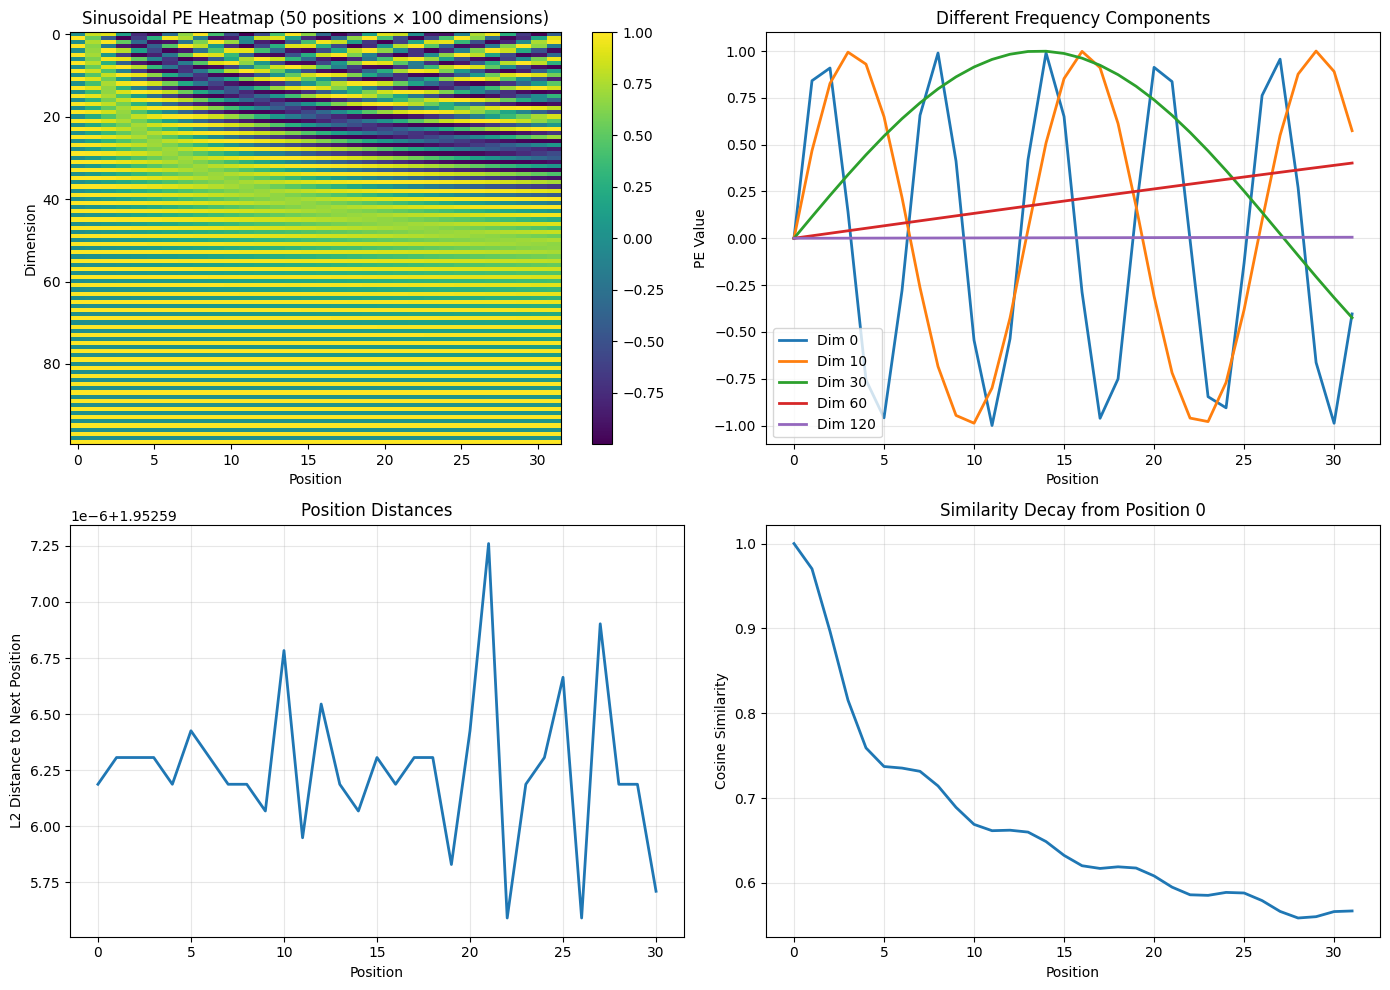

In [23]:
# Visualize sinusoidal positional encodings
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Heatmap
ax = axes[0, 0]
im = ax.imshow(pe[:50, :100].T, cmap='viridis', aspect='auto')
ax.set_xlabel('Position')
ax.set_ylabel('Dimension')
ax.set_title('Sinusoidal PE Heatmap (50 positions × 100 dimensions)')
plt.colorbar(im, ax=ax)

# Plot 2: Different frequency components
ax = axes[0, 1]
# Ensure we don't index past the available positions in `pe`
min_pos = min(50, pe.shape[0])
positions = torch.arange(0, min_pos)
for dim in [0, 10, 30, 60, 120]:
    if dim < d_model:
        ax.plot(positions, pe[positions, dim].numpy(), label=f'Dim {dim}', linewidth=2)
ax.set_xlabel('Position')
ax.set_ylabel('PE Value')
ax.set_title('Different Frequency Components')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Distance between consecutive positions
ax = axes[1, 0]
distances = torch.norm(pe[:-1] - pe[1:], dim=1)
ax.plot(distances.numpy(), linewidth=2)
ax.set_xlabel('Position')
ax.set_ylabel('L2 Distance to Next Position')
ax.set_title('Position Distances')
ax.grid(True, alpha=0.3)

# Plot 4: Similarity to position 0
ax = axes[1, 1]
pos_0_sim = torch.nn.functional.cosine_similarity(
    pe[0].unsqueeze(0), pe, dim=1
)
ax.plot(range(len(pos_0_sim)), pos_0_sim.numpy(), linewidth=2)
ax.set_xlabel('Position')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Similarity Decay from Position 0')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Rotary Position Embedding (RoPE) from Scratch

In [24]:
def apply_rope(x, positions):
    """
    Apply Rotary Position Embedding (RoPE).
    
    RoPE encodes position as 2D rotations in the embedding space.
    For each pair of dimensions (d, d+1), apply a rotation by angle pos * freq_d
    
    Args:
        x: Embeddings of shape (seq_len, d_model)
        positions: Position indices (seq_len,)
    
    Returns:
        Rotated embeddings of shape (seq_len, d_model)
    """
    d = x.shape[-1]
    
    # Compute inverse frequencies: 1 / 10000^(2i/d)
    inv_freq = 1.0 / (10000 ** (torch.arange(0, d, 2).float() / d))
    
    # Compute rotation angles: position * frequency
    # Shape: (seq_len, d/2)
    t = positions.unsqueeze(-1) * inv_freq
    
    # Precompute cos and sin
    cos_t = torch.cos(t)  # (seq_len, d/2)
    sin_t = torch.sin(t)  # (seq_len, d/2)
    
    # Apply 2D rotation to consecutive dimension pairs
    # For dims (0,1), (2,3), ...
    # [x0, x1] -> [x0*cos - x1*sin, x0*sin + x1*cos]
    x_rot = x.clone()
    x_rot[..., 0::2] = x[..., 0::2] * cos_t - x[..., 1::2] * sin_t
    x_rot[..., 1::2] = x[..., 0::2] * sin_t + x[..., 1::2] * cos_t
    
    return x_rot

# Demonstrate RoPE
d_model = 64
seq_len = 16

# Create random embeddings
x = torch.randn(seq_len, d_model)
positions = torch.arange(seq_len)

# Apply RoPE
x_rope = apply_rope(x, positions)

print(f"Original embedding shape: {x.shape}")
print(f"After RoPE shape: {x_rope.shape}")
print(f"\nRoPE property: Rotations preserve L2 norm")
print(f"Original norm: {torch.norm(x[0]).item():.4f}")
print(f"After RoPE norm: {torch.norm(x_rope[0]).item():.4f}")

Original embedding shape: torch.Size([16, 64])
After RoPE shape: torch.Size([16, 64])

RoPE property: Rotations preserve L2 norm
Original norm: 8.1141
After RoPE norm: 8.1141


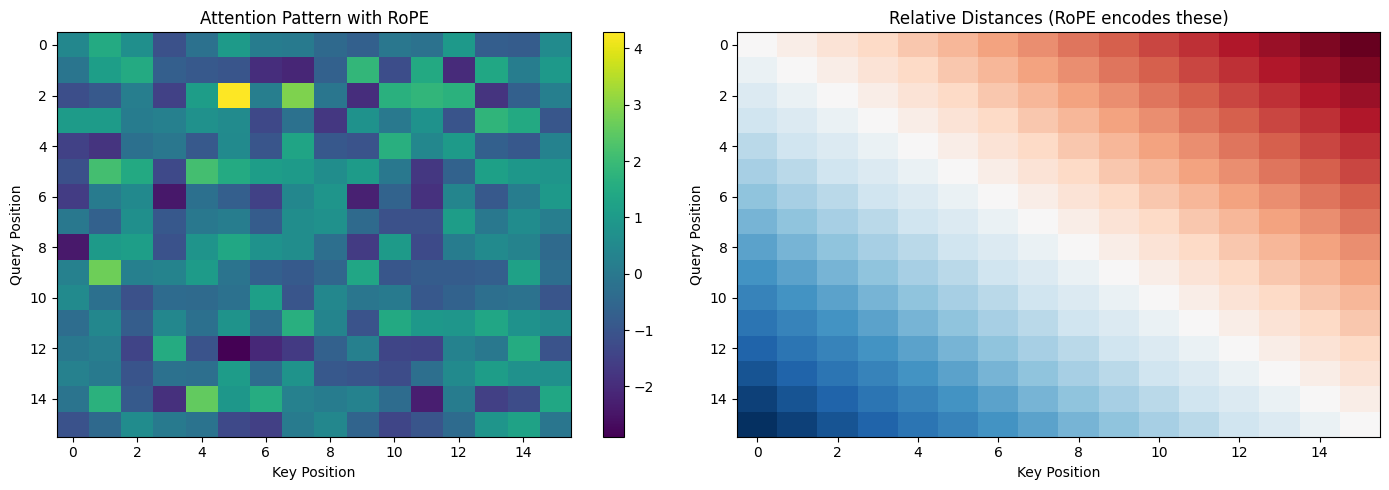

In [25]:
# Visualize RoPE effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Create sample Q, K with RoPE
q = torch.randn(seq_len, d_model)
k = torch.randn(seq_len, d_model)

q_rope = apply_rope(q, positions)
k_rope = apply_rope(k, positions)

# Attention scores
attn_rope = torch.matmul(q_rope, k_rope.T) / math.sqrt(d_model)

# Plot attention scores
ax = axes[0]
im = ax.imshow(attn_rope.detach().numpy(), cmap='viridis', aspect='auto')
ax.set_xlabel('Key Position')
ax.set_ylabel('Query Position')
ax.set_title('Attention Pattern with RoPE')
plt.colorbar(im, ax=ax)

# Plot relative position encoding
ax = axes[1]
relative_distances = torch.arange(seq_len).unsqueeze(0) - torch.arange(seq_len).unsqueeze(1)
ax.imshow(relative_distances.numpy(), cmap='RdBu_r', aspect='auto')
ax.set_xlabel('Key Position')
ax.set_ylabel('Query Position')
ax.set_title('Relative Distances (RoPE encodes these)')

plt.tight_layout()
plt.show()

### Attention with Linear Biases (ALiBi) from Scratch

In [26]:
def alibi_bias(seq_len, num_heads):
    """
    Generate ALiBi (Attention with Linear Biases) positional bias.
    
    Instead of adding positional encodings, directly bias attention scores.
    Different heads have different slopes (penalties for distance).
    
    Args:
        seq_len: Sequence length
        num_heads: Number of attention heads
    
    Returns:
        Bias tensor of shape (1, num_heads, seq_len, seq_len)
    """
    # Compute slopes for each head: 1 / 2^(8h/(n-1))
    # This gives slopes from steep to gentle across heads
    slopes = torch.Tensor([1.0 / (2 ** (8 * h / (num_heads - 1))) for h in range(num_heads)])
    
    # Create distance matrix
    # distance[i, j] = |i - j| (absolute distance between positions)
    positions = torch.arange(seq_len)
    distance = positions.unsqueeze(1) - positions.unsqueeze(0)  # (seq_len, seq_len)
    distance = distance.abs().float()
    
    # Apply slope to distance for each head
    # ALiBi = -slope * distance
    bias = -slopes.unsqueeze(-1).unsqueeze(-1) * distance.unsqueeze(0)  # (num_heads, seq_len, seq_len)
    
    return bias

# Generate ALiBi bias
seq_len = 16
num_heads = 8
alibi = alibi_bias(seq_len, num_heads)

print(f"ALiBi bias shape: {alibi.shape}")
print(f"\nALiBi slopes per head:")
for h in range(num_heads):
    slope = alibi[h, 0, 1] - alibi[h, 0, 0]  # Slope is difference between adjacent positions
    print(f"  Head {h}: penalty = {slope.item():.4f}")

ALiBi bias shape: torch.Size([8, 16, 16])

ALiBi slopes per head:
  Head 0: penalty = -1.0000
  Head 1: penalty = -0.4529
  Head 2: penalty = -0.2051
  Head 3: penalty = -0.0929
  Head 4: penalty = -0.0421
  Head 5: penalty = -0.0190
  Head 6: penalty = -0.0086
  Head 7: penalty = -0.0039


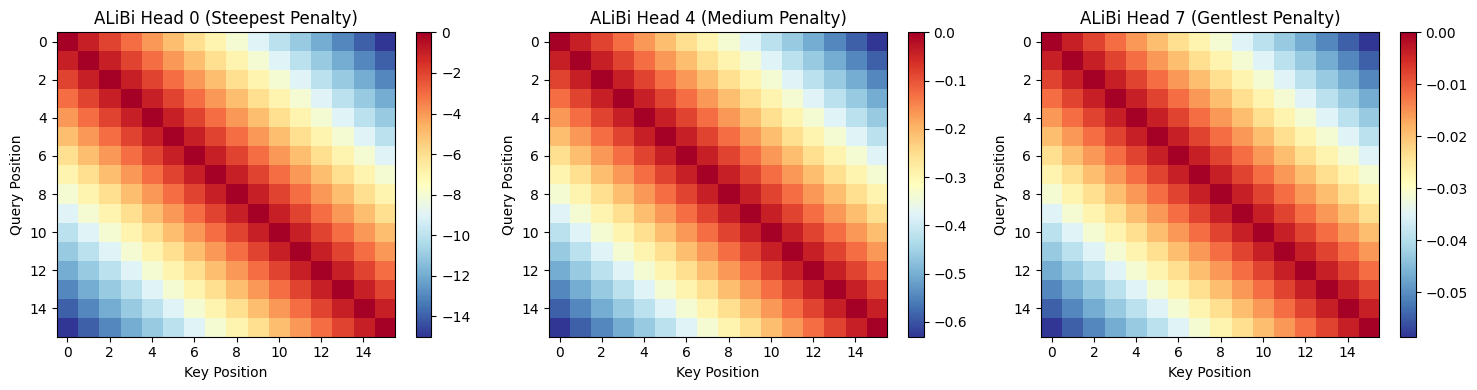

In [27]:
# Visualize ALiBi patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, head in enumerate([0, num_heads // 2, num_heads - 1]):
    ax = axes[idx]
    im = ax.imshow(alibi[head].numpy(), cmap='RdYlBu_r', aspect='auto')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    if head == 0:
        ax.set_title(f'ALiBi Head {head} (Steepest Penalty)')
    elif head == num_heads - 1:
        ax.set_title(f'ALiBi Head {head} (Gentlest Penalty)')
    else:
        ax.set_title(f'ALiBi Head {head} (Medium Penalty)')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## Part 4: Using Modern Libraries

Now let's see how this is done in production with transformers library.

In [28]:
from transformers import AutoTokenizer, AutoModel

# Load pre-trained BERT
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

print(f"Model: {model_name}")
print(f"Tokenizer vocabulary size: {len(tokenizer.vocab)}")
print(f"Model config: {model.config.hidden_size}D embeddings, {model.config.num_attention_heads} heads")

Model: bert-base-uncased
Tokenizer vocabulary size: 30522
Model config: 768D embeddings, 12 heads


In [29]:
# Tokenize and get embeddings
text = samples[10]['input']

# Tokenize
encoded = tokenizer(text, return_tensors="pt")
print(f"Text: {text}")
print(f"Token IDs: {encoded['input_ids'].tolist()}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(encoded['input_ids'][0])}")
print(f"Sequence length: {encoded['input_ids'].shape[1]} tokens")

# Get embeddings
with torch.no_grad():
    outputs = model(**encoded, output_hidden_states=True)
    embeddings = outputs.last_hidden_state

print(f"\nEmbedding shape: {embeddings.shape}")
print(f"Dimension per token: {embeddings.shape[-1]}")


Text: Where's that witch?
Token IDs: [[101, 2073, 1005, 1055, 2008, 6965, 1029, 102]]
Tokens: ['[CLS]', 'where', "'", 's', 'that', 'witch', '?', '[SEP]']
Sequence length: 8 tokens

Embedding shape: torch.Size([1, 8, 768])
Dimension per token: 768

Embedding shape: torch.Size([1, 8, 768])
Dimension per token: 768


In [30]:
# Compare: library vs from-scratch
print("SUMMARY: Input Processing Pipeline")
print("=" * 50)
print(f"\n1. TOKENIZATION")
print(f"   From scratch: SimpleBPE/SimpleWordPiece")
print(f"   Library: transformers.AutoTokenizer")
print(f"   Key insight: Converts text → token IDs\n")

print(f"2. EMBEDDINGS")
print(f"   From scratch: EmbeddingLayer (lookup table)")
print(f"   Library: model.embeddings")
print(f"   Key insight: Maps token IDs → dense vectors\n")

print(f"3. POSITIONAL ENCODINGS")
print(f"   From scratch: sinusoidal_positional_encoding, apply_rope, alibi_bias")
print(f"   Library: Built into model.embeddings")
print(f"   Key insight: Injects sequence position information\n")

print(f"4. COMBINED")
print(f"   Text → Tokens → Embeddings + Position Info → Ready for Transformer")

SUMMARY: Input Processing Pipeline

1. TOKENIZATION
   From scratch: SimpleBPE/SimpleWordPiece
   Library: transformers.AutoTokenizer
   Key insight: Converts text → token IDs

2. EMBEDDINGS
   From scratch: EmbeddingLayer (lookup table)
   Library: model.embeddings
   Key insight: Maps token IDs → dense vectors

3. POSITIONAL ENCODINGS
   From scratch: sinusoidal_positional_encoding, apply_rope, alibi_bias
   Library: Built into model.embeddings
   Key insight: Injects sequence position information

4. COMBINED
   Text → Tokens → Embeddings + Position Info → Ready for Transformer


## Key Insights

1. **Tokenization** is the critical first step - it determines vocabulary size and sequence length
   - BPE learns frequent byte pairs iteratively
   - WordPiece uses likelihood to decide merges

2. **Embeddings** are just lookup tables that get learned during training
   - Each token maps to a point in high-dimensional space
   - Similar tokens end up with similar embeddings

3. **Positional Encodings** solve a critical problem: Transformers don't see position
   - Sinusoidal: Use math functions to encode position (traditional)
   - RoPE: Rotate embeddings based on position (modern, flexible)
   - ALiBi: Directly bias attention by distance (efficient, powerful)

4. **Together** they form the input processing pipeline that makes transformers work